In [4]:
import kagglehub
dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import gc

import nibabel as nib

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print("Random seed set.")

Random seed set.


In [6]:
class MRISegDataset(Dataset):
    def __init__(self, base_path, transform=None):
        """
        Args:
            base_path (str): Path to the dataset folder.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.base_path = base_path
        self.patients = [p for p in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, p))]
        self.transform = transform
        
    def __len__(self):
        return len(self.patients)*155

    def __getitem__(self, ind):
        """
        Args:
            idx (int): Index of the patient to fetch data for.

        Returns:
            dict: A dictionary containing 'image', 'segmentation', and optionally 'patient_id'.
        """
        patient_id = self.patients[ind//155]
        if patient_id == 'BraTS20_Training_355': 
            flair_path = os.path.join(self.base_path, patient_id, "W39_1998.09.19_Segm.nii")
            seg_path = os.path.join(self.base_path, patient_id, "W39_1998.09.19_Segm.nii")
        else:
            flair_path = os.path.join(self.base_path, patient_id, f"{patient_id}_flair.nii")
            seg_path = os.path.join(self.base_path, patient_id, f"{patient_id}_seg.nii")

        flair = nib.load(flair_path).get_fdata()[:, :, ind%155].reshape(1, 240, 240)
        seg = nib.load(seg_path).get_fdata()[:, :, ind%155].reshape(1, 240, 240)
        seg = np.where(seg==4, 3, seg)

        # Normalization
        flair = (flair - 0) / (900 - 0)

        flair = torch.tensor(flair, dtype=torch.float32)
        seg = torch.tensor(seg, dtype=torch.long)
        

        if self.transform:
            flair = self.transform(flair)
            seg = self.transform(seg)

        sample = {'image': flair, 'segmentation': seg, 'patient_id': patient_id}

        return sample

In [7]:
base_path = dataset_path +'/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
brats_dataset = MRISegDataset(base_path=base_path, transform=transforms.Resize((256, 256)))

# Example: Access a single sample
sample = brats_dataset[0]
print("Image shape:", sample['image'].shape)
print("Segmentation shape:", sample['segmentation'].shape)
print("Patient ID:", sample['patient_id'])

Image shape: torch.Size([1, 256, 256])
Segmentation shape: torch.Size([1, 256, 256])
Patient ID: BraTS20_Training_083


In [8]:
batch_size = 10
data_loader = DataLoader(brats_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

for batch in data_loader:
    images = batch['image']  # shape [batch_size, 1, H, W*D]
    segmentations = batch['segmentation']  # shape [batch_size, H, W*D]
    patient_ids = batch['patient_id']
    print(f"Img size: {images.shape}")
    print(f"Seg size: {segmentations.shape}")
    break

Img size: torch.Size([10, 1, 256, 256])
Seg size: torch.Size([10, 1, 256, 256])


In [9]:
img_display = torch.Tensor()
for i in images:
    img_display = torch.concat([img_display, i], dim=2)
img_display = img_display.squeeze()

seg_display = torch.Tensor()
for i in segmentations:
    seg_display = torch.concat([seg_display, i], dim=2)
seg_display = seg_display.squeeze()

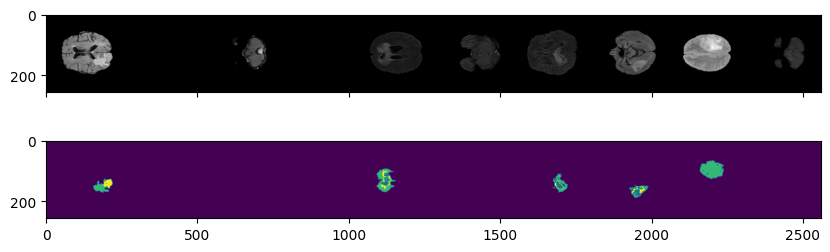

In [10]:
fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(3)
fig.set_figwidth(10)
num = 100
ax[0].imshow(img_display, cmap='gray')
ax[1].imshow(seg_display)

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv2_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    
        self.up4 = nn.ConvTranspose2d(16, 16, stride=2, kernel_size=2)
        self.conv4_1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        encoder2_1 = torch.relu(self.conv2_1(x))
        encoder2_2 = torch.relu(self.conv2_2(encoder2_1))
        encoder2_pool = self.pool2(encoder2_2)

        bottleneck_1 = torch.relu(self.conv3_1(encoder2_pool))
        bottleneck_2 = torch.relu(self.conv3_2(bottleneck_1))

        decode2_up = self.up4(bottleneck_2)
        decode2_concat = torch.cat([decode2_up, encoder2_2], dim=1)
        decode2_1 = torch.relu(self.conv4_1(decode2_concat))
        decode2_2 = torch.relu(self.conv4_2(decode2_1))
        
        return decode2_2

# Instantiate the model
model = UNet()

# Print model summary
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

UNet(
  (conv2_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up4): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv4_1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
17988


In [12]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    pred_class_all = torch.argmax(pred, dim=1)
    
    dice_total = []
    for class_ind in range(4):
        pred_class = (pred_class_all == class_ind).float()
        target_class = (target == class_ind).float()
        
        intersection = (pred_class * target_class).sum(dim=(1,2))
        union = pred_class.sum(dim=(1,2)) + target_class.sum(dim=(1,2))
        
        dice_class = (2. * intersection + smooth) / (union + smooth)
        dice_total.append(dice_class)
    
    return torch.mean(torch.stack(dice_total))

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Currently using: {device}')

Currently using: cuda


In [14]:
batch_size = 16
data_loader = DataLoader(brats_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                         num_workers=2)
print(f"Number of Batches: {len(data_loader)}")

model = UNet()
if torch.cuda.is_available(): 
    model = model.cuda()
    print("Moved to cuda.")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Number of Batches: 3575
Moved to cuda.


In [18]:
num_epochs = 5
training_losses = []
epoch_times = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(data_loader):
        batch_start_time = time.time()
        images = batch['image'].to(device) 
        segmentations = batch['segmentation'].squeeze(1).to(device)

        optimizer.zero_grad()
    
        outputs = model(images)
        loss = criterion(outputs, segmentations)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        del images
        del segmentations
        torch.cuda.empty_cache()
        gc.collect()
        
        if batch_idx%300 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Time: {time.time()-batch_start_time:.4f}, Loss: {loss.item():.4f}")
    
    avg_loss = running_loss / len(data_loader)
    epoch_time = time.time()-epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.4f}, Loss: {avg_loss:.4f}")
    
    torch.save(model.state_dict(), f"UNet1_weights_{epoch}.pth")
    training_losses.append(avg_loss)
    epoch_times.append(epoch_time)

with open("UNet1.txt", "w") as f:
    f.write("Training_losses: \n")
    for i in training_losses: f.write(str(i)+"\n")
    f.write("\nEpoch_times: \n")
    for i in epoch_times: f.write(str(i)+"\n")

Batch 0/3575, Time: 0.6124, Loss: 1.3730
Batch 300/3575, Time: 0.3716, Loss: 0.0370
Batch 600/3575, Time: 0.2932, Loss: 0.0853
Batch 900/3575, Time: 0.3103, Loss: 0.0477
Batch 1200/3575, Time: 0.3483, Loss: 0.0721
Batch 1500/3575, Time: 0.3737, Loss: 0.0345
Batch 1800/3575, Time: 0.3170, Loss: 0.0397
Batch 2100/3575, Time: 0.3725, Loss: 0.0254
Batch 2400/3575, Time: 0.3738, Loss: 0.0420
Batch 2700/3575, Time: 0.2787, Loss: 0.0364
Batch 3000/3575, Time: 0.3777, Loss: 0.0308
Batch 3300/3575, Time: 0.2642, Loss: 0.0591
Epoch 1/5, Time: 1670.3302, Loss: 0.0846
Batch 0/3575, Time: 0.5803, Loss: 0.0495
Batch 300/3575, Time: 0.2675, Loss: 0.0275
Batch 600/3575, Time: 0.2725, Loss: 0.0451
Batch 900/3575, Time: 0.2702, Loss: 0.0597
Batch 1200/3575, Time: 0.2802, Loss: 0.0360
Batch 1500/3575, Time: 0.3841, Loss: 0.0647
Batch 1800/3575, Time: 0.3542, Loss: 0.0763
Batch 2100/3575, Time: 0.3698, Loss: 0.0809
Batch 2400/3575, Time: 0.3731, Loss: 0.0209
Batch 2700/3575, Time: 0.2636, Loss: 0.0563
Bat

[0.08456950147799053, 0.04960683627431835, 0.0488594708051793, 0.04650862699947678, 0.044253290431847524]


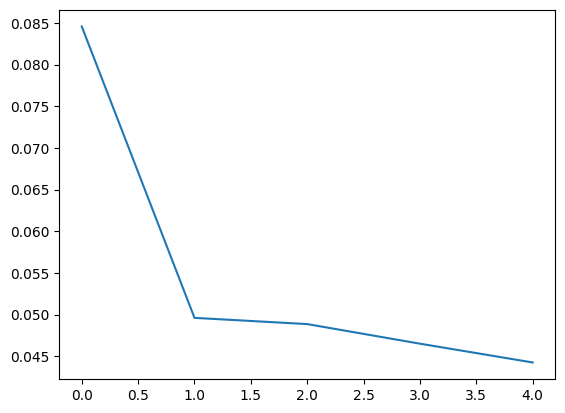

In [22]:
plt.plot(training_losses)
print(training_losses)

[1670.3302488327026, 1631.2070178985596, 1635.161342382431, 1633.0282940864563, 1632.614846944809]


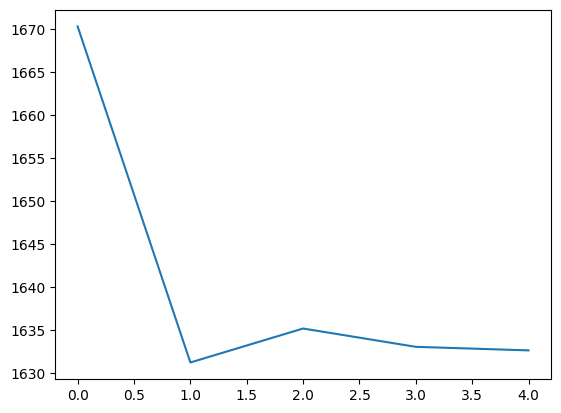

In [23]:
plt.plot(epoch_times)
print(epoch_times)

In [22]:
class UNet_Big(nn.Module):
    def __init__(self):
        super(UNet_Big, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    
        self.up4 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)

        self.up5 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)

    def forward(self, x):
        encoder1_1 = torch.relu(self.conv1_1(x))
        encoder1_2 = torch.relu(self.conv1_2(encoder1_1))
        encoder1_pool = self.pool1(encoder1_2)

        encoder2_1 = torch.relu(self.conv2_1(encoder1_pool))
        encoder2_2 = torch.relu(self.conv2_2(encoder2_1))
        encoder2_pool = self.pool2(encoder2_2)

        bottleneck_1 = torch.relu(self.conv3_1(encoder2_pool))
        bottleneck_2 = torch.relu(self.conv3_2(bottleneck_1))

        decode2_up = self.up4(bottleneck_2)
        decode2_concat = torch.cat([decode2_up, encoder2_2], dim=1)
        decode2_1 = torch.relu(self.conv4_1(decode2_concat))
        decode2_2 = torch.relu(self.conv4_2(decode2_1))

        decode1_up = self.up5(decode2_2)
        decode1_concat = torch.cat([decode1_up, encoder1_2], dim=1)
        decode1_2 = torch.relu(self.conv5_1(decode1_concat))
        decode1_3 = self.conv5_2(decode1_2)

        return decode1_3

# Instantiate the model
model = UNet_Big()

# Print model summary
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

UNet_Big(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up4): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv4_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up5): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv5_1): Conv2d(32, 16, kernel_size=(3, 3), str

In [23]:
model_big = UNet_Big()
if torch.cuda.is_available(): 
    model_big = model_big.cuda()
    print("Moved to cuda.")
criterion_big = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model.parameters(), lr=1e-3)

Moved to cuda.


In [ ]:
num_epochs = 5
training_losses = []
epoch_times = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(data_loader):
        batch_start_time = time.time()
        images = batch['image'].to(device) 
        segmentations = batch['segmentation'].squeeze(1).to(device)

        optimizer.zero_grad()
    
        outputs = model_big(images)
        loss = criterion_big(outputs, segmentations)
        
        loss.backward()
        optimizer_big.step()

        running_loss += loss.item()
        
        del images
        del segmentations
        torch.cuda.empty_cache()
        gc.collect()
        
        if batch_idx%300 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Time: {time.time()-batch_start_time:.4f}, Loss: {loss.item():.4f}")
        
    avg_loss = running_loss / len(data_loader)
    epoch_time = time.time()-epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.4f}, Loss: {avg_loss:.4f}")

    print("Saving weights")
    torch.save(model.state_dict(), f"UNet2_weights_{epoch}.pth")
    training_losses.append(avg_loss)
    epoch_times.append(epoch_time)

with open("UNet2.txt", "w") as f:
    f.write("Training_losses: \n")
    for i in training_losses: f.write(str(i)+"\n")
    f.write("\nEpoch_times: \n")
    for i in epoch_times: f.write(str(i)+"\n")

Batch 0/3575, Time: 0.5242, Loss: 1.3511
Batch 300/3575, Time: 0.2942, Loss: 1.3510
Batch 600/3575, Time: 0.2843, Loss: 1.3519
Batch 900/3575, Time: 0.2883, Loss: 1.3507
Batch 1200/3575, Time: 0.2871, Loss: 1.3513
Batch 1500/3575, Time: 0.3187, Loss: 1.3520
Batch 1800/3575, Time: 0.3931, Loss: 1.3512
Batch 2100/3575, Time: 0.3904, Loss: 1.3510
Batch 2400/3575, Time: 0.2853, Loss: 1.3520
Batch 2700/3575, Time: 0.4026, Loss: 1.3534
Batch 3000/3575, Time: 0.3178, Loss: 1.3508
Batch 3300/3575, Time: 0.3206, Loss: 1.3507
Epoch 1/5, Time: 1725.9952, Loss: 1.3516
Saving weights
Batch 0/3575, Time: 0.3930, Loss: 1.3513
Batch 300/3575, Time: 0.2944, Loss: 1.3507
Batch 600/3575, Time: 0.3509, Loss: 1.3515
Batch 900/3575, Time: 0.3813, Loss: 1.3505
Batch 1200/3575, Time: 0.3675, Loss: 1.3510
Batch 1500/3575, Time: 0.3957, Loss: 1.3515
Batch 1800/3575, Time: 0.2835, Loss: 1.3510
Batch 2100/3575, Time: 0.3037, Loss: 1.3511
Batch 2400/3575, Time: 0.3975, Loss: 1.3508
Batch 2700/3575, Time: 0.3957, L

In [ ]:
with open("UNet2.txt", "r") as f:
    content = f.read()

print(content)

In [ ]:
plt.plot(training_losses)
print(training_losses)

In [ ]:
plt.plot(epoch_times)
print(epoch_times)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)  # Match dimensions

    def forward(self, x):
        identity = self.skip(x)
        out = torch.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity # Reisdual connection
        out = torch.relu(out)
        return out


class UNet_Res(nn.Module):
    def __init__(self):
        super(UNet_Res, self).__init__()

        self.enc1 = ResBlock(1, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResBlock(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = ResBlock(32, 32)

        self.up2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.dec2 = ResBlock(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = ResBlock(32, 16)

        self.final_conv = nn.Conv2d(16, 4, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        bottleneck = self.bottleneck(enc2_pool)

        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        out = self.final_conv(dec1)
        return out


model = UNet_Res()

print(model)
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

In [ ]:
model_res = UNet_Res()
if torch.cuda.is_available(): 
    model_res = model_res.cuda()
    print("Moved to cuda.")
    criterion_res = nn.CrossEntropyLoss()
optimizer_res = torch.optim.Adam(model_res.parameters(), lr=1e-4)

In [ ]:
num_epochs = 5
training_losses = []
epoch_times = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(data_loader):
        batch_start_time = time.time()
        images = batch['image'].to(device) 
        segmentations = batch['segmentation'].squeeze(1).to(device)

        optimizer.zero_grad()
    
        outputs = model_res(images)
        loss = criterion_res(outputs, segmentations)
        
        loss.backward()
        optimizer_res.step()

        running_loss += loss.item()
        
        del images
        del segmentations
        torch.cuda.empty_cache()
        gc.collect()
        
        if batch_idx%300 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Time: {time.time()-batch_start_time:.4f}, Loss: {loss.item():.4f}")
        
    avg_loss = running_loss / len(data_loader)
    epoch_time = time.time()-epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.4f}, Loss: {avg_loss:.4f}")

    print("Saving weights")
    torch.save(model.state_dict(), f"UNet3_weights_{epoch}.pth")
    training_losses.append(avg_loss)
    epoch_times.append(epoch_time)

with open("UNet3.txt", "w") as f:
    f.write("Training_losses: \n")
    for i in training_losses: f.write(str(i)+"\n")
    f.write("\nEpoch_times: \n")
    for i in epoch_times: f.write(str(i)+"\n")

In [ ]:
with open("UNet3.txt", "r") as f:
    content = f.read()

print(content)

In [ ]:
plt.plot(training_losses)
print(training_losses)

In [ ]:
plt.plot(epoch_times)
print(epoch_times)

In [ ]:
base_path = dataset_path +'/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id = 'BraTS20_Training_003'

Flair = nib.load(f'{base_path}/{patient_id}/{patient_id}_flair.nii')
Seg = nib.load(f'{base_path}/{patient_id}/{patient_id}_seg.nii')
T1 = nib.load(f'{base_path}/{patient_id}/{patient_id}_t1.nii')
T1ce = nib.load(f'{base_path}/{patient_id}/{patient_id}_t1ce.nii')
T2 = nib.load(f'{base_path}/{patient_id}/{patient_id}_t2.nii')

patient2_mri = np.concatenate([Flair.get_fdata()[np.newaxis,:,:,:], T1.get_fdata()[np.newaxis,:,:,:], 
                              T1ce.get_fdata()[np.newaxis,:,:,:], T2.get_fdata()[np.newaxis,:,:,:],
                              Seg.get_fdata()[np.newaxis,:,:,:]])

print(patient2_mri.shape)

In [ ]:
fig, ax = plt.subplots(1,2)
num = 70
a = Flair.get_fdata()[:, :, num]
ax[0].imshow(a, cmap='gray')
a = Seg.get_fdata()[:, :, num]
ax[1].imshow(a)
set(a.flatten())

In [ ]:
class ExperimentalModel(nn.Module):
    def __init__(self):
        super(ExperimentalModel, self).__init__()
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding='same',dtype=torch.float16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding='same',dtype=torch.float16)
        self.conv3 = nn.Conv3d(32, 4, kernel_size=3, padding='same',dtype=torch.float16)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x

model = ExperimentalModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
time_start = time.time()
for epoch in range(5):
    epoch_start = time.time()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y.float())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Time Taken for epoch: {time.time()-epoch_start:.2f}")

print(f"Total time: {time.time()-time_start:.2f}")

In [ ]:
base_path = dataset_path +'/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id_base = 'BraTS20_Training_00'

for i in range(1,11):
    id = str(i)
    patient_id = patient_id_base+id
    Flair = nib.load(f'{base_path}/{patient_id}/{patient_id}_flair.nii')
    Seg = nib.load(f'{base_path}/{patient_id}/{patient_id}_seg.nii')
    T1 = nib.load(f'{base_path}/{patient_id}/{patient_id}_t1.nii')
    T1ce = nib.load(f'{base_path}/{patient_id}/{patient_id}_t1ce.nii')
    T2 = nib.load(f'{base_path}/{patient_id}/{patient_id}_t2.nii')

    patient2_mri = np.concatenate([Flair.get_fdata()[np.newaxis,:,:,:], T1.get_fdata()[np.newaxis,:,:,:], 
                                  T1ce.get_fdata()[np.newaxis,:,:,:], T2.get_fdata()[np.newaxis,:,:,:],
                                  Seg.get_fdata()[np.newaxis,:,:,:]])

    print(patient2_mri.shape)

In [ ]:
i = 0
for param in model.parameters():
    i+=param.numel()

print(i)